In [109]:
import pandas as pd 

df = pd.read_csv("C:\\Users\\Eli\\Desktop\\news_dataset.csv", index_col=0)

In [110]:
#drop NaN values
df = df.dropna()
#reset index column after removing NaN values
df.reset_index(drop=True, inplace= True)
df 

,title,content,publication,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake
...,...,...,...,...
27980,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
27981,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
27982,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
27983,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


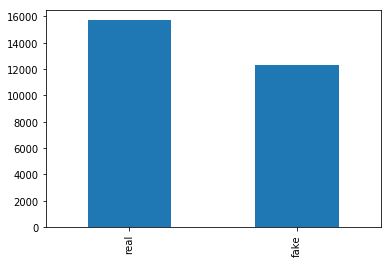

In [111]:
df['label'].value_counts().plot(kind='bar')

In [112]:
#text preprocessing imports
import nltk
import string

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

In [113]:
#Remove HTML data after the text was scraped 
def remove_html(text):
    soup = BeautifulSoup(text)
    html_free = soup.get_text()
    return html_free

In [114]:
#remove punctuation that we dont want to have tokenized
def remove_punctuation(text):
    no_punctuation = "".join([c for c in text if c not in string.punctuation])
    return no_punctuation

In [115]:
#tokenize each row using regex tokenizer, creating a list of words at every white space '\w' 
tokenizer = RegexpTokenizer(r'\w+')

In [116]:
#remove stopwords such as 'this' and 'in' as these would be the most common words when extracting features 
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [117]:
stemmer = PorterStemmer()

In [118]:
#normalize each word by removing the commoner morphological and inflexional endings
def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text 

In [122]:
#group all the functions into one function call that we can use on individual paragraphs later and to preprocess the dataset
def preprocess_text(x):
    x = remove_html(x)
    x = remove_punctuation(x)
    x = tokenizer.tokenize(x.lower())
    x = remove_stopwords(x)
    x = word_stemmer(x)
    return x

In [123]:
#preprocess the entire 'content' column
df['content'] = df['content'].apply(lambda x: preprocess_text(x))

In [126]:
#checking to see if it worked on the entire dataframe
df['content']

0        print pay back money plu interest entir famili...
1        attorney gener loretta lynch plead fifth barra...
2        red state fox news sunday report morn anthoni ...
3        email kayla mueller prison tortur isi chanc re...
4        email healthcar reform make america great sinc...
                               ...                        
27980    uber driver keith avila pick passeng look like...
27981    crew friday continu search lake eri plane carr...
27982    obama administr announc massiv effort help dis...
27983    stori updat new law michigan prohibit local go...
27984    nation first recreat marijuana shop open nearl...
Name: content, Length: 27985, dtype: object

In [127]:
#save the processed dataset onto a new file for later use.
df.to_csv("C:\\Users\\Eli\\Desktop\\processed_news_dataset.csv")

In [128]:
def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
    
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break

    accuracy=correct/float(len(eval_items))
    print(correct, total)
    return accuracy

In [147]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "counts" in type:
        
        # COUNT VECTORIZER
        cv= CountVectorizer(binary=False, max_df=0.90, min_df=0.01)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF VECTORIZER
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   
    
def train_model_lr(df,field="content",feature_rep="counts",top_k=1):
    
    logging.info("Starting model training...")
    
    # train/test split
    training_data, testing_data = train_test_split(df,random_state = 42,)

    # get labels from the 'label' column
    Y_train=training_data['label'].values
    Y_test=testing_data['label'].values
     
    # get features
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # start linear regression
    logging.info("Training a Logistical Regression Model...")
    lr = LogisticRegression(verbose=1, solver='liblinear',random_state=42, C=5, penalty='l2',max_iter=1000)
    model=lr.fit(X_train,Y_train)

    # get prediction
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # get accuracy values
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy

def train_model_nb(df,field="content", feature_rep="counts", top_k=1):
    logging.info("Starting model training...")
    
    # train, test splits with seed 
    training_data, testing_data = train_test_split(df,random_state = 42,)

    # y_labels
    Y_train=training_data['label'].values
    Y_test=testing_data['label'].values
     
    # extract features 
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # start naive bayes model
    logging.info("Training a Logistic Regression Model...")
    nb = MultinomialNB()
    model_nb=nb.fit(X_train,Y_train)

    # get prediction
    preds=get_top_k_predictions(model_nb,X_test,top_k)
    
    # turn predicted vals and ground truths into a list
    eval_items=collect_preds(Y_test,preds)
    
    # get accuracy values
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model_nb,feature_transformer,accuracy

In [145]:
field='content'
feature_rep='tfidf'
top_k=1

model,transformer,accuracy=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}".format(accuracy))

2020-03-30 20:34:03,528 : INFO : Starting model training...
2020-03-30 20:34:03,533 : INFO : Extracting features and creating vocabulary...
2020-03-30 20:34:17,301 : INFO : Training a Logistic Regression Model...
[LibLinear]2020-03-30 20:34:18,421 : INFO : Starting evaluation...
2020-03-30 20:34:18,423 : INFO : Done training and evaluation.
6574 0

Accuracy=0.9395455195083607


In [148]:
field='content'
feature_rep='tfidf'
top_k=1

model,transformer,accuracy=train_model_nb(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}".format(accuracy))

2020-03-30 20:38:59,126 : INFO : Starting model training...
2020-03-30 20:38:59,131 : INFO : Extracting features and creating vocabulary...
2020-03-30 20:39:12,915 : INFO : Training a Logistic Regression Model...
2020-03-30 20:39:13,003 : INFO : Starting evaluation...
2020-03-30 20:39:13,007 : INFO : Done training and evaluation.
4669 0

Accuracy=0.6672859797055881


In [134]:
test_features=transformer.transform([preprocess_text('''Writing in the Mail today, he warmed up by blasting Wonder Woman star Gal Gadot for her much-criticised, "tone deaf" version of Imagine that was supposed to lift people's spirits but left many cringing.

But he soon moved on to weightier targets, saying 47-year-old Idris had a place on his "idiot" list despite having contracted coronavirus himself - because he exposed the fact that A-listers were getting tested while NHS staff couldn't.

Piers later attacked High School Musical's Vanessa Hudgens, who called the virus a "bunch of bulls**t", saying she was in "urgent need of shutting the f*** up".

His ire then turned on singer Sam Smith, who earned a place on Piers' list thanks to a series of pictures they shared of a "meltdown" in self-isolation .''')])
get_top_k_predictions(model,test_features,1)

[['fake']]

In [150]:
test_features=transformer.transform([preprocess_text('''Writing in the Mail today, he warmed up by blasting Wonder Woman star Gal Gadot for her much-criticised, "tone deaf" version of Imagine that was supposed to lift people's spirits but left many cringing.

But he soon moved on to weightier targets, saying 47-year-old Idris had a place on his "idiot" list despite having contracted coronavirus himself - because he exposed the fact that A-listers were getting tested while NHS staff couldn't.

Piers later attacked High School Musical's Vanessa Hudgens, who called the virus a "bunch of bulls**t", saying she was in "urgent need of shutting the f*** up".

His ire then turned on singer Sam Smith, who earned a place on Piers' list thanks to a series of pictures they shared of a "meltdown" in self-isolation.''')])
get_top_k_predictions(model,test_features,1)

[['real']]